<a href="https://colab.research.google.com/github/Beast-Hunter/TopsisPretrainedModels/blob/main/Topsis_PreTrained_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer
import time

In [3]:
def topsis(data, weights, impacts):
    normalized_data = data / np.sqrt(np.sum(data**2, axis=0))

    weighted_data = normalized_data * weights

    ideal_solution = np.max(weighted_data, axis=0)
    negative_ideal_solution = np.min(weighted_data, axis=0)

    for i in range(len(impacts)):
        if impacts[i] == '-':
            ideal_solution[i], negative_ideal_solution[i] = negative_ideal_solution[i], ideal_solution[i]

    distance_positive = np.sqrt(np.sum((weighted_data - ideal_solution)**2, axis=1))
    distance_negative = np.sqrt(np.sum((weighted_data - negative_ideal_solution)**2, axis=1))

    performance_score = distance_negative / (distance_positive + distance_negative)

    rank = np.argsort(performance_score)[::-1] + 1

    return performance_score, rank


In [4]:
def load_models():
    return {
        "DeBERTa": pipeline("text-classification", model="microsoft/deberta-base"),
        "Electra": pipeline("text-classification", model="google/electra-small-discriminator"),
        "Longformer": pipeline("text-classification", model="allenai/longformer-base-4096"),
        "MobileBERT": pipeline("text-classification", model="google/mobilebert-uncased"),
        "TinyBERT": pipeline("text-classification", model="huawei-noah/TinyBERT_General_4L_312D"),
    }


In [5]:
def evaluate_model(name, model_id, texts, labels, label_names):
    start = time.time()
    predictions = model_id(texts, truncation=True, padding=True)
    end = time.time()

    pred_indices = [int(pred["label"].replace("LABEL_", "")) for pred in predictions]
    pred_names = [label_map[i] for i in pred_indices]

    accuracy = sum(1 for pred, true in zip(pred_names, label_names) if pred == true) / len(labels)

    model_size = sum(p.numel() for p in model.model.parameters()) * 4 / (1024**2)

    results = {
        "model": model_name,
        "accuracy": accuracy,
        "inference_time": end - start,
        "model_size": model_size
    }

    return results

In [6]:
from datasets import load_dataset

dataset = load_dataset("ag_news", split="test[:200]")
texts = dataset["text"]
labels = dataset["label"]

label_map = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}
label_names = [label_map[l] for l in labels]

models = load_models()
results = []
for model_name, model in models.items():
    result = evaluate_model(model_name, model, texts, labels, label_names)
    if result:
        results.append(result)

results_df = pd.DataFrame(results)
results_df = results_df.set_index('model')
print(results_df)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electr

            accuracy  inference_time  model_size
model                                           
DeBERTa        0.265        9.085056  530.982430
Electra        0.235        2.930762   51.686531
Longformer     0.305       14.396672  567.096687
MobileBERT     0.305        7.603389   93.776375
TinyBERT       0.305        0.770657   54.744240


In [8]:
weights = [0.5, 0.25, 0.25]
impacts = ['+', '-', '-']

topsis_results, rank = topsis(results_df, weights, impacts)
print("\nTOPSIS Results:")
topsis_results


TOPSIS Results:


<ipython-input-3-09738774a5b6>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ideal_solution[i], negative_ideal_solution[i] = negative_ideal_solution[i], ideal_solution[i]
<ipython-input-3-09738774a5b6>:11: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ideal_solution[i], negative_ideal_solution[i] = negative_ideal_solution[i], ideal_solution[i]


,0
model,
DeBERTa,0.282467
Electra,0.782704
Longformer,0.184213
MobileBERT,0.667791
TinyBERT,0.996113


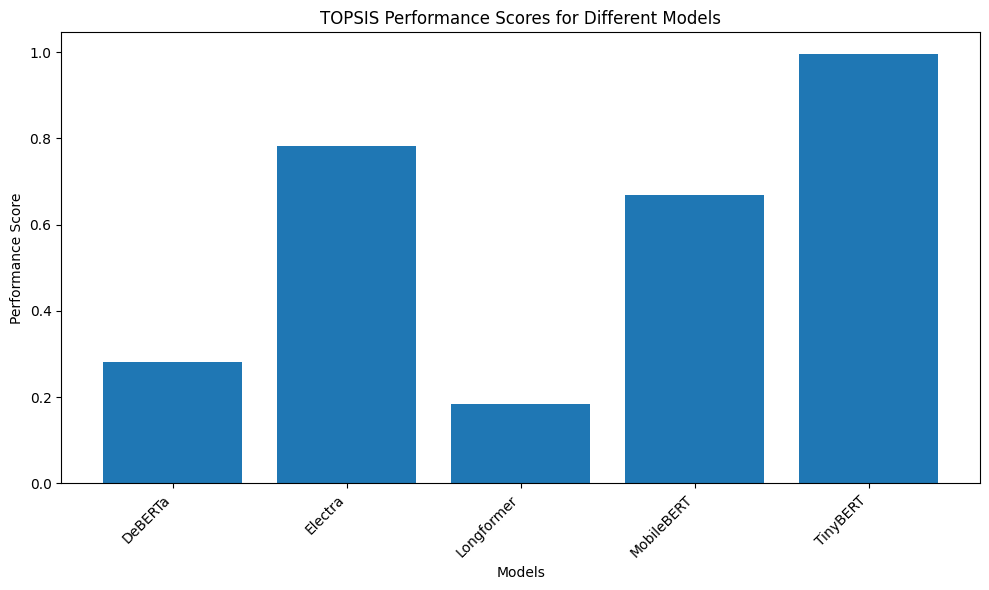

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, topsis_results)
plt.xlabel("Models")
plt.ylabel("Performance Score")
plt.title("TOPSIS Performance Scores for Different Models")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()